In [287]:
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.plotting import plot_efficient_frontier
import matplotlib.pyplot as plt
from pypfopt.discrete_allocation import DiscreteAllocation
from matplotlib.ticker import FuncFormatter

import warnings

# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [288]:
from matplotlib import rc

# Set Times New Roman font globally
rc('font', family='serif', serif='Times New Roman')
plt.rcParams.update({'font.size': 14})
rc('mathtext', fontset='custom', rm='Times New Roman')

In [289]:
df = pd.read_csv('../../data/final_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [290]:
df.head()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2005-10-10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000163
2005-10-11,1.003231,1.006833,1.004578,0.998658,0.998084,0.995925,1.000217
2005-10-12,0.999670,0.997110,0.996675,0.996056,0.996517,0.991573,1.000275
2005-10-13,0.981077,0.986449,0.997260,0.993734,0.993465,0.988179,1.000333
2005-10-14,0.973370,0.987997,0.994278,0.993174,0.993525,0.989778,1.000390


In [291]:
asset_names = ['RE', 'PE', 'Equity', 'IG CB', 'GB', 'HY CB', 'Money']

In [292]:
t1 = ("2021-11-01", "2022-11-01")
t2 = ("2007-06-01", "2008-06-01")
t3 = ("2022-11-01", "2023-11-01")

t = [t1,t2,t3]

In [293]:
scenarios = {
    "2007-06-01varnormal" : "A1",
    "2007-06-01cvarnormal" : "A2",
    "2007-06-01vartstudent" : "A3",
    "2007-06-01cvartstudent" : "A4",
    "2021-11-01varnormal" : "B1",
    "2021-11-01cvarnormal" : "B2",
    "2021-11-01vartstudent" : "B3",
    "2021-11-01cvartstudent" : "B4",
    "2022-11-01varnormal" : "C1",
    "2022-11-01cvarnormal" : "C2",
    "2022-11-01vartstudent" : "C3",
    "2022-11-01cvartstudent" : "C4",
}

### Comparing with NSGA-II algorithm

In [294]:
import json
import numpy as np

def load_pareto_fronts(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    
    all_runs = []
    for entry in data:
        pareto_front = []
        for solution in entry.get("solutions", []):
            # Ensure solution is a dictionary
            if isinstance(solution, dict):
                weights = np.array(solution.get("weights", []))
                period = solution.get("period", [])
                cov_matrix = df[(df.index <= period[0])].cov()
                expected_return = solution.get("expected_return", 0) / 1000000
                
                std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) if weights.size > 0 else 0
                pareto_front.append({
                    "weights": weights.tolist(),  # Convert numpy array to list for JSON compatibility
                    "expected_return": expected_return,
                    "SCR_risk": solution.get("SCR_risk", 0),
                    "risk_measure": solution.get("risk_measure", ""),
                    "distribution": solution.get("distribution", ""),
                    "period": period,
                    "std_dev": std_dev  # Add standard deviation
                })
        all_runs.append(pareto_front)
    return all_runs

json_file_path = "../pareto_front_results.json"
pareto_fronts = load_pareto_fronts(json_file_path)

In [295]:
def plot_pareto_and_vanilla_mvo(pareto_fronts, df):
    # Calculate mean returns and covariance matrix for Vanilla MVO
    mu = mean_historical_return(df)
    S = CovarianceShrinkage(df).ledoit_wolf()

    # Create a plot for the Pareto fronts and Vanilla MVO
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate a colormap for Pareto fronts
    cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))  # Use 'tab10' colormap for distinct colors

    # Store legend items in a dictionary for sorting
    legend_items = {}

    # Plot Pareto fronts
    for i, pareto_front in enumerate(pareto_fronts):
        # Extract weights, expected returns, and standard deviations
        weights_list = [np.array(solution["weights"]) for solution in pareto_front]
        expected_returns = [(solution["expected_return"])  for solution in pareto_front]
        std_devs = [(solution["std_dev"]) for solution in pareto_front]
        end_test_period = pareto_front[0]["period"][0]
        risk_measure = pareto_front[0]["risk_measure"]
        distribution = pareto_front[0]["distribution"]

        scenario = end_test_period + risk_measure + distribution

        scenario = scenarios[scenario]

        # Use the same color for all portfolios in this Pareto front
        color = cmap(i)

        # Add scatter plot to the axes
        scatter = ax.scatter(std_devs, expected_returns, label=scenario, color=color, alpha=0.7)
        
        # Store the label and corresponding scatter in the dictionary
        legend_items[scenario] = scatter

    ef_vanilla = EfficientFrontier(mu, S)  # Create a new instance
    plot_efficient_frontier(ef_vanilla, ax=ax, show_assets=False, color="grey")

    ef_max_sharpe = EfficientFrontier(mu, S)  
    weights = ef_max_sharpe.max_sharpe()  
    cleaned_weights = ef_max_sharpe.clean_weights()
    ret, vol, sharpe = ef_max_sharpe.portfolio_performance(verbose=True)

    # Output weights
    print("Optimal weights for the Max Sharpe Ratio portfolio:")
    for asset, weight in cleaned_weights.items():
        print(f"{asset}: {weight:.2%}")
    ax.scatter(vol, ret, marker=".", color="r", s=100, label="Vanilla MVO Max Sharpe Portfolio", zorder=10)

    asset_vols = np.sqrt(np.diag(S))

    for i, asset in enumerate(asset_names):
        ax.scatter((asset_vols[i]), (mu[i]), color="black", s=50, zorder=5)  
        ax.text(asset_vols[i]  + 0.006, mu[i] - 0.002, f" {asset}", fontsize=14, color="black", zorder=10)

    # Create the legend with sorted labels
    sorted_legend_items = sorted(legend_items.items(), key=lambda x: x[0])  # Sort by label (key)
    sorted_labels = [item[0] for item in sorted_legend_items]
    sorted_handles = [item[1] for item in sorted_legend_items]
    ax.legend(sorted_handles + [plt.Line2D([], [], color='r', marker='.', linestyle='None', markersize=10)],
              sorted_labels + ["Tangency (Max Sharpe)"], fontsize=14, frameon = False)

    # Customize the plot
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.1f}"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y*100:.1f}"))
    plt.xlabel(r"$\sigma_p$ (%)")
    plt.ylabel(r"$r_p$ (%)")
    plt.tight_layout()
    plt.show()

TIME PERIOD: ('2021-11-01', '2022-11-01')


/Users/simenstang/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/var/folders/4j/dxkybcjx57g2_q7pvt8nkd040000gn/T/ipykernel_47769/1200269596.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))  # Use 'tab10' colormap for distinct colors


Expected annual return: 4.6%
Annual volatility: 2.9%
Sharpe Ratio: 1.58
Optimal weights for the Max Sharpe Ratio portfolio:
REEL: 0.00%
PE: 0.00%
MSCIWORLD: 2.89%
IG: 27.32%
GOV: 21.05%
HY: 32.89%
EONIA: 15.85%


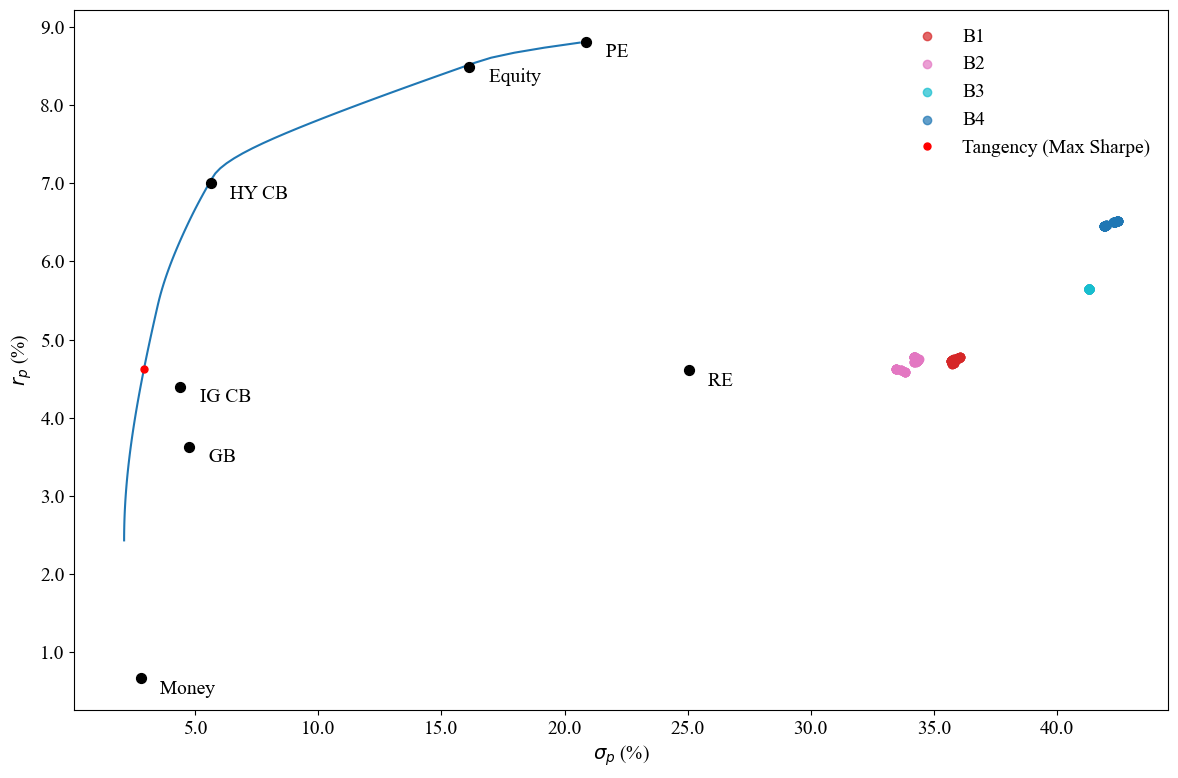

TIME PERIOD: ('2007-06-01', '2008-06-01')


/Users/simenstang/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/var/folders/4j/dxkybcjx57g2_q7pvt8nkd040000gn/T/ipykernel_47769/1200269596.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))  # Use 'tab10' colormap for distinct colors


Expected annual return: 17.2%
Annual volatility: 9.1%
Sharpe Ratio: 1.89
Optimal weights for the Max Sharpe Ratio portfolio:
REEL: 9.63%
PE: 35.89%
MSCIWORLD: 21.35%
IG: 4.71%
GOV: 0.00%
HY: 22.01%
EONIA: 6.41%


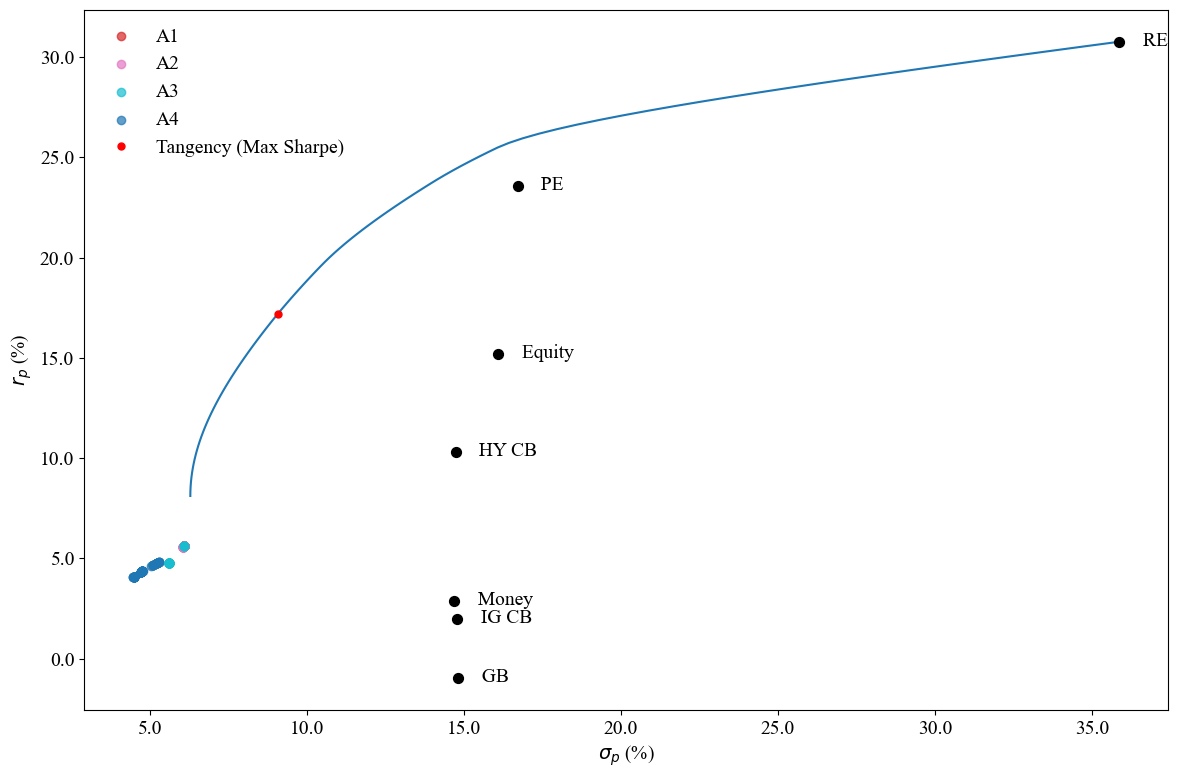

TIME PERIOD: ('2022-11-01', '2023-11-01')


/Users/simenstang/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/var/folders/4j/dxkybcjx57g2_q7pvt8nkd040000gn/T/ipykernel_47769/1200269596.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))  # Use 'tab10' colormap for distinct colors


Expected annual return: 3.5%
Annual volatility: 3.0%
Sharpe Ratio: 1.16
Optimal weights for the Max Sharpe Ratio portfolio:
REEL: 0.00%
PE: 0.00%
MSCIWORLD: 3.04%
IG: 20.89%
GOV: 15.56%
HY: 37.58%
EONIA: 22.92%


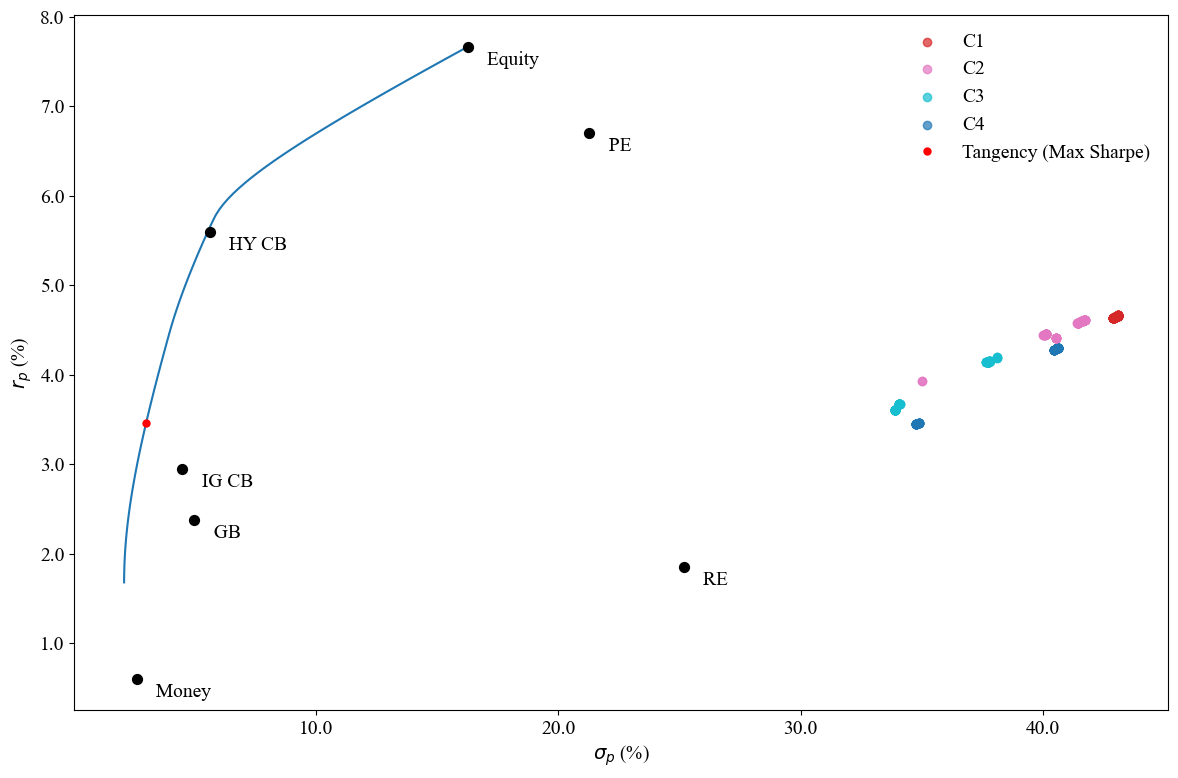

In [296]:
for i in t:
    new_df = df[(df.index <= i[0])]
    print("TIME PERIOD:", i)
    valid_pareto_fronts = []

    for pareto_front in pareto_fronts:
        portfolio = pareto_front[0]
        start_test_period = portfolio["period"][0]

        if i[0] == start_test_period:
            valid_pareto_fronts.append(pareto_front)
            continue
        
    plot_pareto_and_vanilla_mvo(valid_pareto_fronts, new_df)

In [297]:
def plot_pareto_and_vanilla_mvo(pareto_fronts, df):
    # Calculate mean returns and covariance matrix for Vanilla MVO
    mu = mean_historical_return(df)  # Returns in decimals
    S = CovarianceShrinkage(df).ledoit_wolf()  # Covariance matrix

    # Create a plot for the Pareto fronts and Vanilla MVO
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate a colormap for Pareto fronts
    # Use 'tab10' colormap for distinct colors
    cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))

    # Store legend items in a dictionary for sorting
    legend_items = {}

    # Plot Pareto fronts
    for i, pareto_front in enumerate(pareto_fronts):
        # Extract weights, expected returns, and standard deviations
        weights_list = [np.array(solution["weights"])
                        for solution in pareto_front]
        expected_returns = [solution["expected_return"] *
                            100 for solution in pareto_front]  # Convert to %
        std_devs = [solution["std_dev"] *
                    100 for solution in pareto_front]  # Convert to %
        end_test_period = pareto_front[0]["period"][0]
        risk_measure = pareto_front[0]["risk_measure"]
        distribution = pareto_front[0]["distribution"]

        scenario = end_test_period + risk_measure + distribution

        scenario = scenarios[scenario]

        # Use the same color for all portfolios in this Pareto front
        color = cmap(i)

        # Add scatter plot to the axes
        scatter = ax.scatter(std_devs, expected_returns,
                             label=scenario, color=color, alpha=0.7)

        # Store the label and corresponding scatter in the dictionary
        legend_items[scenario] = scatter

    # Plot Vanilla MVO efficient frontier
    ef_vanilla = EfficientFrontier(mu*100, S*100)  # Create a new instance
    plot_efficient_frontier(ef_vanilla, ax=ax, show_assets=False)

    # Optimize Vanilla MVO for the maximum Sharpe ratio and plot the portfolio
    # Create another new instance for max Sharpe ratio
    ef_max_sharpe = EfficientFrontier(mu, S)
    ef_max_sharpe.max_sharpe()
    ret, vol, sharpe = ef_max_sharpe.portfolio_performance(verbose=True)
    ax.scatter(vol * 100, ret * 100, marker=".", color="r", s=100,
               label="Vanilla MVO Max Sharpe Portfolio", zorder=10)

    # Plot individual assets as black dots with labels
    # Standard deviation (volatility) for each asset
    asset_vols = np.sqrt(np.diag(S))

    for i, asset in enumerate(asset_names):
        ax.scatter(asset_vols[i] * 100, mu[i] * 100,
                   color="black", s=50, zorder=5)  # Convert to %
        ax.text(asset_vols[i] * 100 + 0.5, mu[i] * 100 - 0.2,
                f" {asset}", fontsize=14, color="black", zorder=10)

    # Create the legend with sorted labels
    sorted_legend_items = sorted(
        legend_items.items(), key=lambda x: x[0])  # Sort by label (key)
    sorted_labels = [item[0] for item in sorted_legend_items]
    sorted_handles = [item[1] for item in sorted_legend_items]
    ax.legend(sorted_handles + [plt.Line2D([], [], color='r', marker='.', linestyle='None', markersize=10)],
              sorted_labels + ["Tangency (Max Sharpe)"], fontsize=14, frameon=False)

    # Format the x-axis (volatility) and y-axis (expected return) as percentages
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}%"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}%"))

    # Customize the plot
    plt.xlabel(r"$\sigma_p$ (%)")
    plt.ylabel(r"$r_p$ (%)")
    plt.tight_layout()
    plt.show()

TIME PERIOD: ('2021-11-01', '2022-11-01')


/Users/simenstang/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/var/folders/4j/dxkybcjx57g2_q7pvt8nkd040000gn/T/ipykernel_47769/3548218495.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))


Expected annual return: 4.6%
Annual volatility: 2.9%
Sharpe Ratio: 1.58


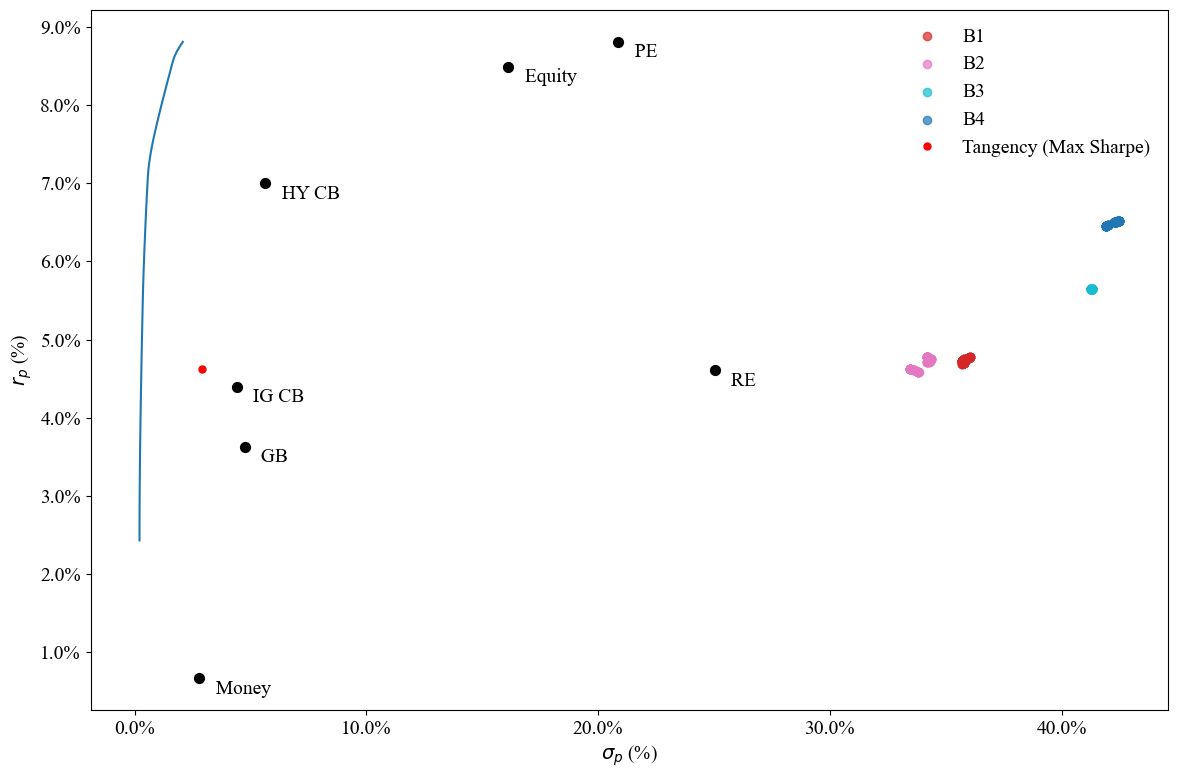

TIME PERIOD: ('2007-06-01', '2008-06-01')


/Users/simenstang/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/var/folders/4j/dxkybcjx57g2_q7pvt8nkd040000gn/T/ipykernel_47769/3548218495.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))


Expected annual return: 17.2%
Annual volatility: 9.1%
Sharpe Ratio: 1.89


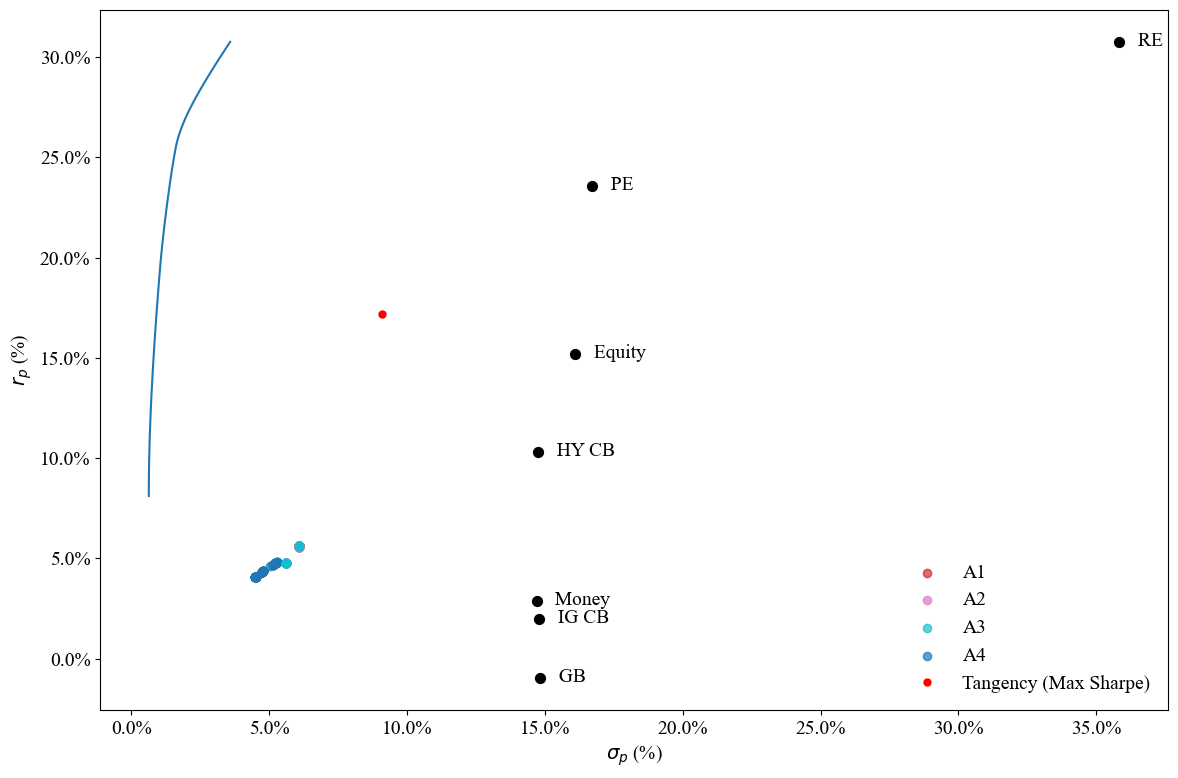

TIME PERIOD: ('2022-11-01', '2023-11-01')


/Users/simenstang/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/var/folders/4j/dxkybcjx57g2_q7pvt8nkd040000gn/T/ipykernel_47769/3548218495.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))


Expected annual return: 3.5%
Annual volatility: 3.0%
Sharpe Ratio: 1.16


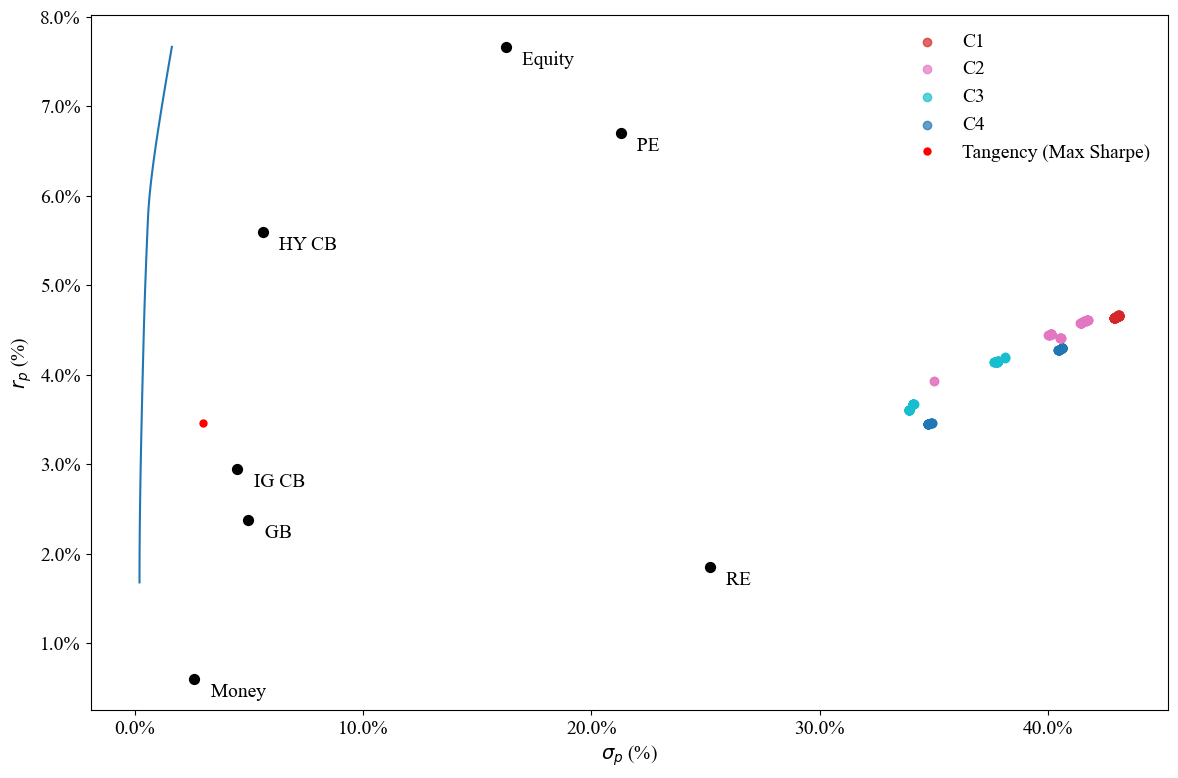

In [298]:
for i in t:
    new_df = df[(df.index <= i[0])]
    print("TIME PERIOD:", i)
    valid_pareto_fronts = []

    for pareto_front in pareto_fronts:
        portfolio = pareto_front[0]
        start_test_period = portfolio["period"][0]

        if i[0] == start_test_period:
            valid_pareto_fronts.append(pareto_front)
            continue

    plot_pareto_and_vanilla_mvo(valid_pareto_fronts, new_df)

In [299]:
def plot_pareto_and_vanilla_mvo(pareto_fronts, df):
    # Calculate mean returns and covariance matrix for Vanilla MVO
    mu = mean_historical_return(df)  # Returns in decimals
    S = CovarianceShrinkage(df).ledoit_wolf()  # Covariance matrix

    # Create a plot for the Pareto fronts and Vanilla MVO
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate a colormap for Pareto fronts
    # Use 'tab10' colormap for distinct colors
    cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))

    # Store legend items in a dictionary for sorting
    legend_items = {}

    # Plot Pareto fronts
    for i, pareto_front in enumerate(pareto_fronts):
        # Extract weights, expected returns, and standard deviations
        expected_returns = [solution["expected_return"] *
                            100 for solution in pareto_front]  # Convert to %
        std_devs = [solution["std_dev"] *
                    100 for solution in pareto_front]  # Convert to %
        end_test_period = pareto_front[0]["period"][0]
        risk_measure = pareto_front[0]["risk_measure"]
        distribution = pareto_front[0]["distribution"]

        scenario = end_test_period + risk_measure + distribution
        scenario = scenarios[scenario]

        # Use the same color for all portfolios in this Pareto front
        color = cmap(i)

        # Add scatter plot to the axes
        scatter = ax.scatter(std_devs, expected_returns,
                             label=scenario, color=color, alpha=0.7)
        legend_items[scenario] = scatter

    # Efficient Frontier (Vanilla MVO)
    ef_vanilla = EfficientFrontier(mu, S)  # Create a new instance

    # Generate the efficient frontier by varying target returns
    # 50 points from min to max return
    target_returns = np.linspace(mu.min(), mu.max(), 50)
    risks = []
    returns = []

    for target_return in target_returns:
        # Solve for minimum volatility at target return
        ef_vanilla.efficient_return(target_return)
        ret, vol, _ = ef_vanilla.portfolio_performance()
        risks.append(vol * 100)  # Convert volatility to percentage
        returns.append(ret * 100)  # Convert return to percentage

    # Plot the efficient frontier
    ax.plot(risks, returns, label="Efficient Frontier",
            color="green", linewidth=2)

    # Optimize Vanilla MVO for the maximum Sharpe ratio and plot the portfolio
    # Create another new instance for max Sharpe ratio
    ef_max_sharpe = EfficientFrontier(mu, S)
    ef_max_sharpe.max_sharpe()
    ret, vol, sharpe = ef_max_sharpe.portfolio_performance(verbose=True)
    ax.scatter(vol * 100, ret * 100, marker=".", color="r", s=100,
               label="Vanilla MVO Max Sharpe Portfolio", zorder=10)

    # Plot individual assets as black dots with labels
    # Standard deviation (volatility) for each asset
    asset_vols = np.sqrt(np.diag(S))

    for i, asset in enumerate(asset_names):
        ax.scatter(asset_vols[i] * 100, mu[i] * 100,
                   color="black", s=50, zorder=5)  # Convert to %
        ax.text(asset_vols[i] * 100 + 0.5, mu[i] * 100 - 0.2,
                f" {asset}", fontsize=14, color="black", zorder=10)

    # Create the legend with sorted labels
    sorted_legend_items = sorted(
        legend_items.items(), key=lambda x: x[0])  # Sort by label (key)
    sorted_labels = [item[0] for item in sorted_legend_items]
    sorted_handles = [item[1] for item in sorted_legend_items]
    ax.legend(sorted_handles +
              [plt.Line2D([], [], color='r', marker='.',
                          linestyle='None', markersize=10)],
              sorted_labels + ["Tangency (Max Sharpe)"], fontsize=14, frameon=False)

    # Format the x-axis (volatility) and y-axis (expected return) as percentages
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}%"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}%"))

    # Customize the plot
    plt.xlabel(r"$\sigma_p$ (%)")
    plt.ylabel(r"$r_p$ (%)")
    plt.tight_layout()
    plt.show()

TIME PERIOD: ('2021-11-01', '2022-11-01')


/Users/simenstang/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/var/folders/4j/dxkybcjx57g2_q7pvt8nkd040000gn/T/ipykernel_47769/1075988857.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", len(pareto_fronts))


ValueError: target_return must be lower than the maximum possible return

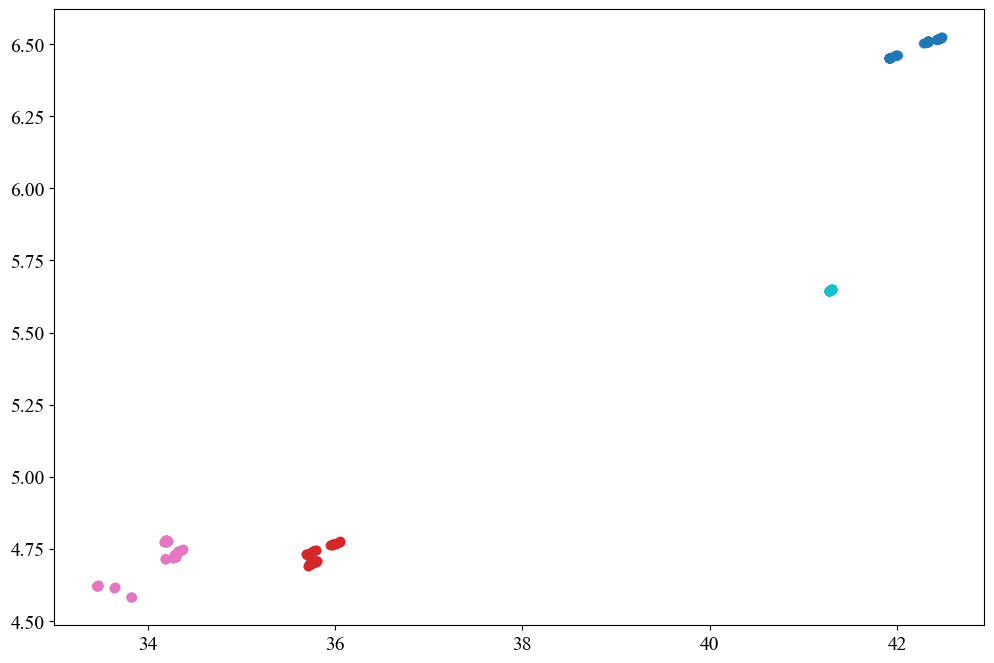

In [300]:
for i in t:
    new_df = df[(df.index <= i[0])]
    print("TIME PERIOD:", i)
    valid_pareto_fronts = []

    for pareto_front in pareto_fronts:
        portfolio = pareto_front[0]
        start_test_period = portfolio["period"][0]

        if i[0] == start_test_period:
            valid_pareto_fronts.append(pareto_front)
            continue

    plot_pareto_and_vanilla_mvo(valid_pareto_fronts, new_df)